# Dog Breed Detector 🐶

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
class_folder_paths = ['../input/70-dog-breedsimage-data-set/test/'+x for x in os.listdir('../input/70-dog-breedsimage-data-set/test/')]

In [3]:
for class_folder_path in class_folder_paths:
    print('{0}:'.format(class_folder_path), ' ', len(os.listdir(class_folder_path)))

../input/70-dog-breedsimage-data-set/test/Cocker:   10
../input/70-dog-breedsimage-data-set/test/American Spaniel:   10
../input/70-dog-breedsimage-data-set/test/Bichon Frise:   10
../input/70-dog-breedsimage-data-set/test/Beagle:   10
../input/70-dog-breedsimage-data-set/test/Pomeranian:   10
../input/70-dog-breedsimage-data-set/test/Bermaise:   10
../input/70-dog-breedsimage-data-set/test/Schnauzer:   10
../input/70-dog-breedsimage-data-set/test/Groenendael:   10
../input/70-dog-breedsimage-data-set/test/Komondor:   10
../input/70-dog-breedsimage-data-set/test/Afghan:   10
../input/70-dog-breedsimage-data-set/test/Bluetick:   10
../input/70-dog-breedsimage-data-set/test/Pekinese:   10
../input/70-dog-breedsimage-data-set/test/Chow:   10
../input/70-dog-breedsimage-data-set/test/Maltese:   10
../input/70-dog-breedsimage-data-set/test/Elk Hound:   10
../input/70-dog-breedsimage-data-set/test/Irish Wolfhound:   10
../input/70-dog-breedsimage-data-set/test/Shih-Tzu:   10
../input/70-dog-

In [4]:
TRAIN_DIR = '../input/70-dog-breedsimage-data-set/train/'
VAL_DIR = '../input/70-dog-breedsimage-data-set/valid/'
TEST_DIR = '../input/70-dog-breedsimage-data-set/test/'

In [5]:
train_dogs=os.listdir(TRAIN_DIR)

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

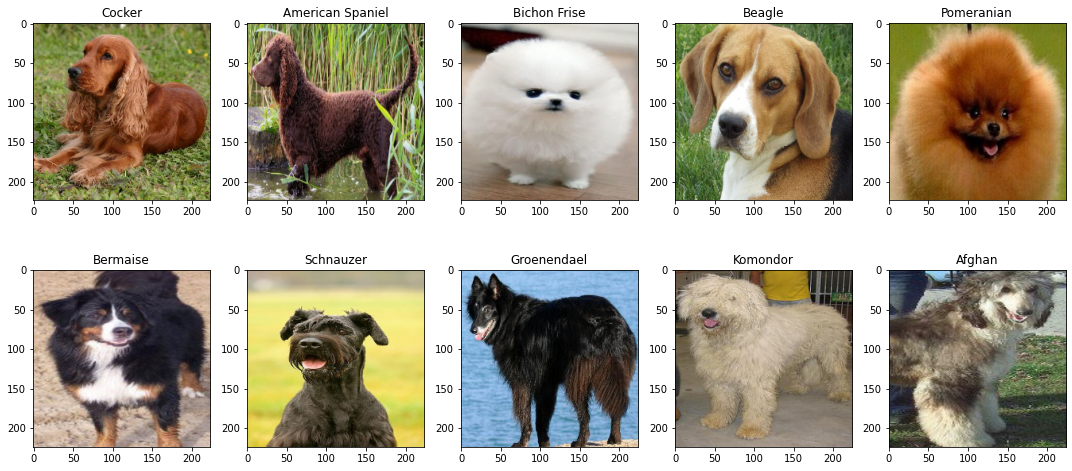

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
for i, ax in enumerate(axes.flat):
    dir = TRAIN_DIR + "/" + train_dogs[i] + "/"
    ax.imshow(Image.open(dir + os.listdir(dir)[0]))
    ax.set_title(train_dogs[i])
plt.tight_layout()
plt.show()

## Data Preprocessing

In [8]:
train_data_gen = ImageDataGenerator(horizontal_flip = True,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2)

train_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                     target_size = (224, 224),
                                                     color_mode = 'rgb',
                                                     batch_size = 32,
                                                     class_mode ='categorical',
                                                     shuffle = True)

val_data_gen = ImageDataGenerator()

val_generator = val_data_gen.flow_from_directory(VAL_DIR,
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = False)
val_data_gen = ImageDataGenerator()

test_generator = val_data_gen.flow_from_directory(TEST_DIR,
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = False)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [9]:
labels = train_generator.class_indices
class_mapping = dict((v,k) for k,v in labels.items())
class_mapping

{0: 'Afghan',
 1: 'African Wild Dog',
 2: 'Airedale',
 3: 'American Hairless',
 4: 'American Spaniel',
 5: 'Basenji',
 6: 'Basset',
 7: 'Beagle',
 8: 'Bearded Collie',
 9: 'Bermaise',
 10: 'Bichon Frise',
 11: 'Blenheim',
 12: 'Bloodhound',
 13: 'Bluetick',
 14: 'Border Collie',
 15: 'Borzoi',
 16: 'Boston Terrier',
 17: 'Boxer',
 18: 'Bull Mastiff',
 19: 'Bull Terrier',
 20: 'Bulldog',
 21: 'Cairn',
 22: 'Chihuahua',
 23: 'Chinese Crested',
 24: 'Chow',
 25: 'Clumber',
 26: 'Cockapoo',
 27: 'Cocker',
 28: 'Collie',
 29: 'Corgi',
 30: 'Coyote',
 31: 'Dalmation',
 32: 'Dhole',
 33: 'Dingo',
 34: 'Doberman',
 35: 'Elk Hound',
 36: 'French Bulldog',
 37: 'German Sheperd',
 38: 'Golden Retriever',
 39: 'Great Dane',
 40: 'Great Perenees',
 41: 'Greyhound',
 42: 'Groenendael',
 43: 'Irish Spaniel',
 44: 'Irish Wolfhound',
 45: 'Japanese Spaniel',
 46: 'Komondor',
 47: 'Labradoodle',
 48: 'Labrador',
 49: 'Lhasa',
 50: 'Malinois',
 51: 'Maltese',
 52: 'Mex Hairless',
 53: 'Newfoundland',
 54

## Model Initialization (MobileNET) 

In [10]:
before_mobilenet = Sequential([Input((224,224,3)),
                             Lambda(preprocess_input)])

mobilenet = MobileNetV2(input_shape = (224,224,3), include_top = False)

after_mobilenet = Sequential([GlobalAveragePooling2D(),
                             Dropout(0.2),
                             Dense(70, activation = 'softmax')])

model = Sequential([before_mobilenet, mobilenet, after_mobilenet])

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
opt = Adam(learning_rate=0.00001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
model.build(((None, 224, 224, 3)))

before_mobilenet.summary()
mobilenet.summary()
after_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   

## Training the Model

In [13]:
train_cb = ModelCheckpoint('./model/', save_best_only = True)

model.fit(train_generator, validation_data = val_generator, callbacks = [train_cb], epochs = 20)

Epoch 1/20
249/249 [==============================] - 150s 556ms/step - loss: 4.1956 - accuracy: 0.0540 - val_loss: 3.5333 - val_accuracy: 0.1671


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
249/249 [==============================] - 119s 478ms/step - loss: 3.2224 - accuracy: 0.2662 - val_loss: 2.4435 - val_accuracy: 0.5057


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/20
249/249 [==============================] - 119s 476ms/step - loss: 2.3437 - accuracy: 0.4873 - val_loss: 1.5793 - val_accuracy: 0.6800


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/20
249/249 [==============================] - 119s 477ms/step - loss: 1.7103 - accuracy: 0.6311 - val_loss: 1.0961 - val_accuracy: 0.7986


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/20
249/249 [==============================] - 118s 472ms/step - loss: 1.2946 - accuracy: 0.7192 - val_loss: 0.8493 - val_accuracy: 0.8500


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/20
249/249 [==============================] - 118s 474ms/step - loss: 1.0649 - accuracy: 0.7570 - val_loss: 0.7184 - val_accuracy: 0.8686


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/20
249/249 [==============================] - 119s 476ms/step - loss: 0.8976 - accuracy: 0.7892 - val_loss: 0.6450 - val_accuracy: 0.8814


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/20
249/249 [==============================] - 118s 475ms/step - loss: 0.7812 - accuracy: 0.8131 - val_loss: 0.5898 - val_accuracy: 0.8971


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/20
249/249 [==============================] - 118s 473ms/step - loss: 0.6945 - accuracy: 0.8276 - val_loss: 0.5611 - val_accuracy: 0.9014


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/20
249/249 [==============================] - 118s 475ms/step - loss: 0.6254 - accuracy: 0.8370 - val_loss: 0.5310 - val_accuracy: 0.9086


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/20
249/249 [==============================] - 118s 473ms/step - loss: 0.5733 - accuracy: 0.8528 - val_loss: 0.5126 - val_accuracy: 0.9100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/20
249/249 [==============================] - 119s 477ms/step - loss: 0.5330 - accuracy: 0.8621 - val_loss: 0.5036 - val_accuracy: 0.9157


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/20
249/249 [==============================] - 118s 475ms/step - loss: 0.5022 - accuracy: 0.8681 - val_loss: 0.4853 - val_accuracy: 0.9200


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/20
249/249 [==============================] - 120s 480ms/step - loss: 0.4662 - accuracy: 0.8755 - val_loss: 0.4751 - val_accuracy: 0.9214


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/20
249/249 [==============================] - 118s 474ms/step - loss: 0.4325 - accuracy: 0.8803 - val_loss: 0.4653 - val_accuracy: 0.9257


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/20
249/249 [==============================] - 119s 476ms/step - loss: 0.4106 - accuracy: 0.8898 - val_loss: 0.4611 - val_accuracy: 0.9214


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/20
249/249 [==============================] - 119s 475ms/step - loss: 0.3779 - accuracy: 0.9028 - val_loss: 0.4560 - val_accuracy: 0.9271


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/20
249/249 [==============================] - 119s 476ms/step - loss: 0.3522 - accuracy: 0.9056 - val_loss: 0.4498 - val_accuracy: 0.9314


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/20
249/249 [==============================] - 118s 474ms/step - loss: 0.3476 - accuracy: 0.9057 - val_loss: 0.4458 - val_accuracy: 0.9257


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/20
249/249 [==============================] - 118s 474ms/step - loss: 0.3208 - accuracy: 0.9134 - val_loss: 0.4465 - val_accuracy: 0.9257


In [14]:
model.save('MobileNetV2_model.h5')

In [15]:
model.evaluate(test_generator)

22/22 [==============================] - 4s 161ms/step - loss: 0.1654 - accuracy: 0.9629


[0.16537855565547943, 0.9628571271896362]

In [16]:
from tensorflow.keras.models import load_model
model = load_model('MobileNetV2_model.h5')

In [17]:
inp1 = cv2.imread('../input/70-dog-breedsimage-data-set/valid/Afghan/01.jpg') #Afghan
inp2 = cv2.imread('../input/70-dog-breedsimage-data-set/valid/Boxer/01.jpg') #Boxer
inp3 = cv2.imread('../input/70-dog-breedsimage-data-set/valid/Bull Mastiff/01.jpg') #Bull Mastiff

inputs = [inp1, inp2, inp3]


In [18]:
inputs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in inputs]

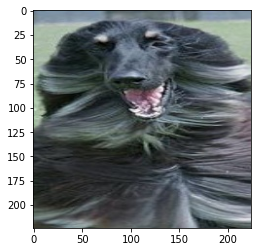

In [19]:
plt.imshow(inputs[0])

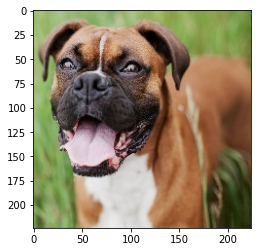

In [20]:
plt.imshow(inputs[1])

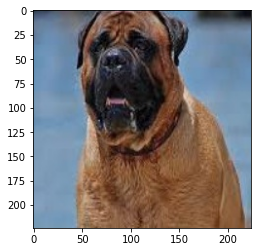

In [21]:
plt.imshow(inputs[2])